### This notebook fits a BERTopic model to the data set and creates topic visualisations.

In [4]:
import numpy as np
import pandas as pd

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethsmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Run these two lines to have all plots appear on GitHub (do not run to use interactive plots within this notebook):
import plotly.io as pio

pio.renderers.default = "png"

In [6]:
# Set directory and file paths
READ_DIR = "../data/processed"

FILENAME = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace"

EMBEDDING_TWHINBERT = "twitter_airline_sentiment_cleaned_emoji_urls_html_symbols@#_quotes_currency_whitespace_twhin-bert-base.npy"

In [7]:
# Load embeddings
embeddings_twhinbert = np.load(f"{READ_DIR}/{EMBEDDING_TWHINBERT}")

In [8]:
# Load text data
df = pd.read_csv(f"{READ_DIR}/{FILENAME}.csv")

#### Set customisable parameters for BERTopic components:

In [9]:
# Parameters for UMAP
n_neighbors = 15
n_components = 5
min_dist = 0.1
metric_umap = "cosine"
random_state = 0

# UMAP model
reducer = UMAP(
    n_neighbors=n_neighbors,
    n_components=n_components,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Parameters for HDBScan
min_cluster_size = 15
min_samples = 5
metric_hdbscan = "euclidean"
cluster_selection_method = "eom"

# HDBScan model
clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric=metric_hdbscan,
    cluster_selection_method=cluster_selection_method,
    prediction_data=True,
)

# The lower and upper boundary of the range of n-values for different word n-grams
# or char n-grams to be extracted:
ngram_range = (1, 2)

#### Create functions to fit BERTopic model:

In [7]:
def get_bertmodel(ngram_range, umap_model, hdbscan_model):
    # Convert a collection of text documents to a matrix of token counts:
    vectorizer = CountVectorizer(
        stop_words=stopwords.words("english"),
        tokenizer=TweetTokenizer().tokenize,
        token_pattern=None,
        ngram_range=ngram_range,
    )

    # Fit BERTopic model with customisation:
    topic_model = BERTopic(
        vectorizer_model=vectorizer, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    return topic_model


def get_topics_probs(model, docs, embeddings):
    topics, probs = model.fit_transform(docs, embeddings=embeddings)
    return topics, probs


def fit_bert(docs, embeddings, ngram_range, umap_model, hdbscan_model):
    bertmodel = get_bertmodel(
        ngram_range=ngram_range, umap_model=umap_model, hdbscan_model=hdbscan_model
    )

    topics, probs = get_topics_probs(model=bertmodel, docs=docs, embeddings=embeddings)

    return bertmodel, topics, probs

#### Fit BERTopic model using TWHINBERT embeddings:

In [8]:
bertmodel_twhinbert, topics_twhinbert, probs_twhinbert = fit_bert(
    docs=list(df.clean_text),
    embeddings=embeddings_twhinbert,
    ngram_range=ngram_range,
    umap_model=reducer,
    hdbscan_model=clusterer,
)

##### Display the results table:
note: Topic -1 represents outliers 

In [9]:
df_bertopics_twhinbert = bertmodel_twhinbert.get_topic_info()
print("Number of topics: {}".format(len(df_bertopics_twhinbert)))
df_bertopics_twhinbert["Percentage"] = round(
    df_bertopics_twhinbert["Count"] / df_bertopics_twhinbert["Count"].sum() * 100, 2
)
df_bertopics_twhinbert

Number of topics: 93


,Topic,Count,Name,Representation,Representative_Docs,Percentage
0,-1,9369,-1_flight_get_thanks_service,"[flight, get, thanks, service, cancelled, time...",[spent 1.5 hours in line trying to get on a fl...,64.94
1,0,972,0_ive_call_hold_email,"[ive, call, hold, email, get, hours, minutes, ...","[Finally got a call from AA, but it was an aut...",6.74
2,1,400,1_please_sucks_guys_go,"[please, sucks, guys, go, please please, thank...","[please help us get home tomorrow!!!!!, sucks....",2.77
3,2,205,2_great_staff_crew_thanks,"[great, staff, crew, thanks, helpful, service,...",[great trip today! Thanks to the crew flying u...,1.42
4,3,178,3_foldedhands_foldedhands foldedhands_facewith...,"[foldedhands, foldedhands foldedhands, facewit...",[YOU ARE THE BEST!!! YOU ARE AMAZING!!! FOLLOW...,1.23
...,...,...,...,...,...,...
88,87,15,87_sitting runway_leaving_sitting_runway,"[sitting runway, leaving, sitting, runway, boa...","[sitting on the runway in Newark, they won't l...",0.10
89,88,15,88_telling call_keeps_keeps telling_error message,"[telling call, keeps, keeps telling, error mes...",[every time I search a flight your site logs m...,0.10
90,89,15,89_bae_coat_love_enjoy,"[bae, coat, love, enjoy, clappinghands, youre,...","["": Well captured, Brittany! We love the cloud...",0.10
91,90,15,90_follow_follow dm_dm_info sure,"[follow, follow dm, dm, info sure, follow send...",[please follow me so I can DM you about someth...,0.10


#### Choose a topic number and print data from the corresponding row:

In [10]:
topic_num = 0
for i, v in df_bertopics_twhinbert.iloc[topic_num + 1].items():
    print(f"{i} : {v}")

Topic : 0
Count : 972
Name : 0_ive_call_hold_email
Representation : ['ive', 'call', 'hold', 'email', 'get', 'hours', 'minutes', 'bag', 'im', 'plane']
Representative_Docs : ["Finally got a call from AA, but it was an automated voice that hung up on me! I called back & it says it'll be 2 more hours.", '. All I get is an automated system that hangs up on me. I finally get a message that some will call me back in 2 hours.', 'I tried. We were hung up on, twice. After speaking with someone, then put on hold for 45 minutes. No resolution.']
Percentage : 6.74


##### For each topic, we can observe the most important words, sorted in decreasing order based on the c-TF-IDF score:

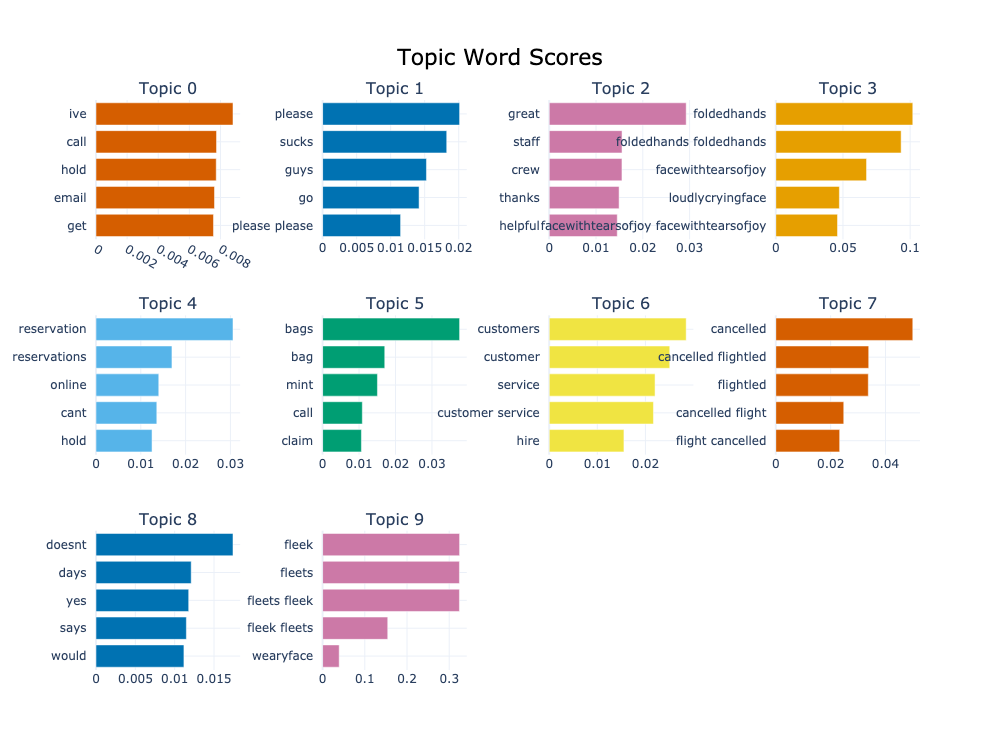

In [11]:
barchart = bertmodel_twhinbert.visualize_barchart(top_n_topics=10)
barchart.show()

#### Create a 2D representation of the topics:

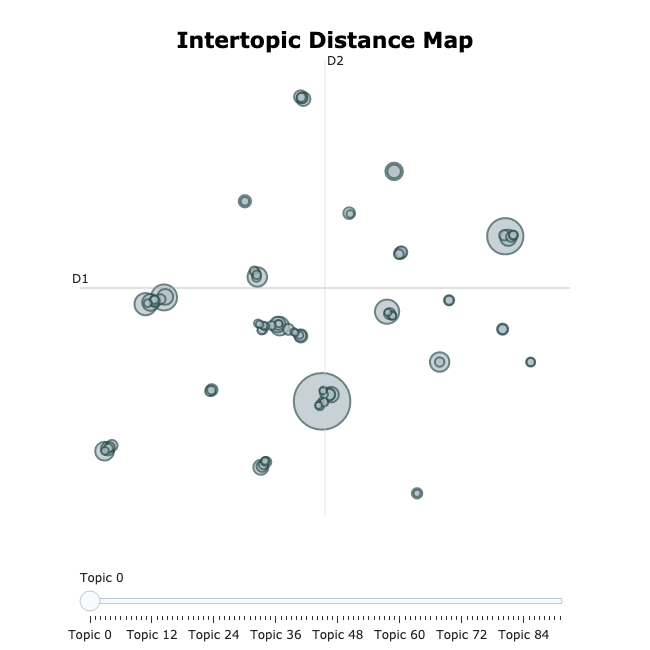

In [12]:
distance_map = bertmodel_twhinbert.visualize_topics()
distance_map.show()

#### Visualise topic similarity with a heatmap:

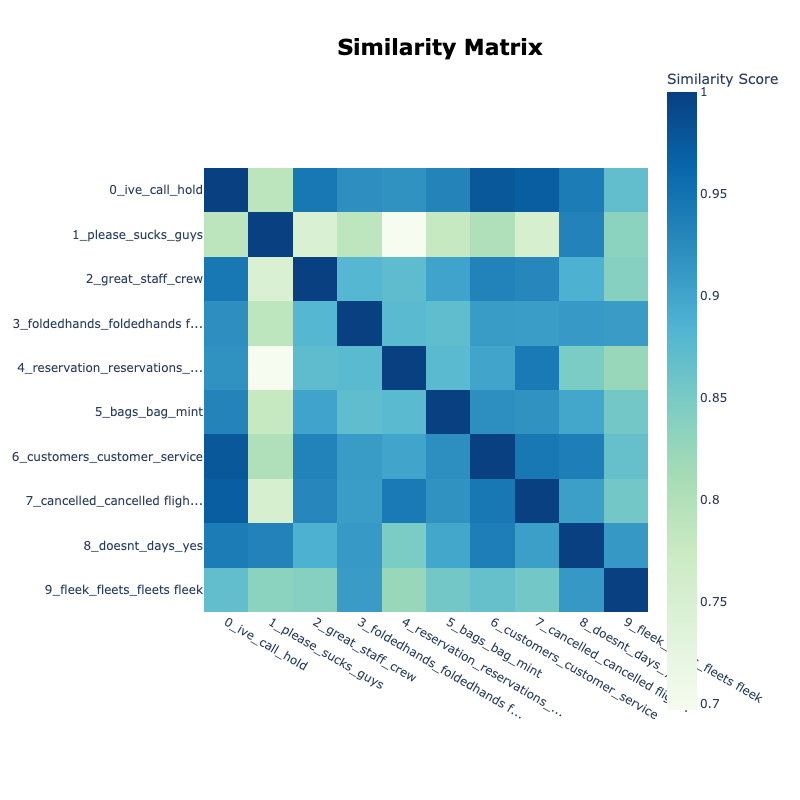

In [13]:
similarity_matrix = bertmodel_twhinbert.visualize_heatmap(top_n_topics=10)
similarity_matrix.show()

#### Now visualise the documents within topics:

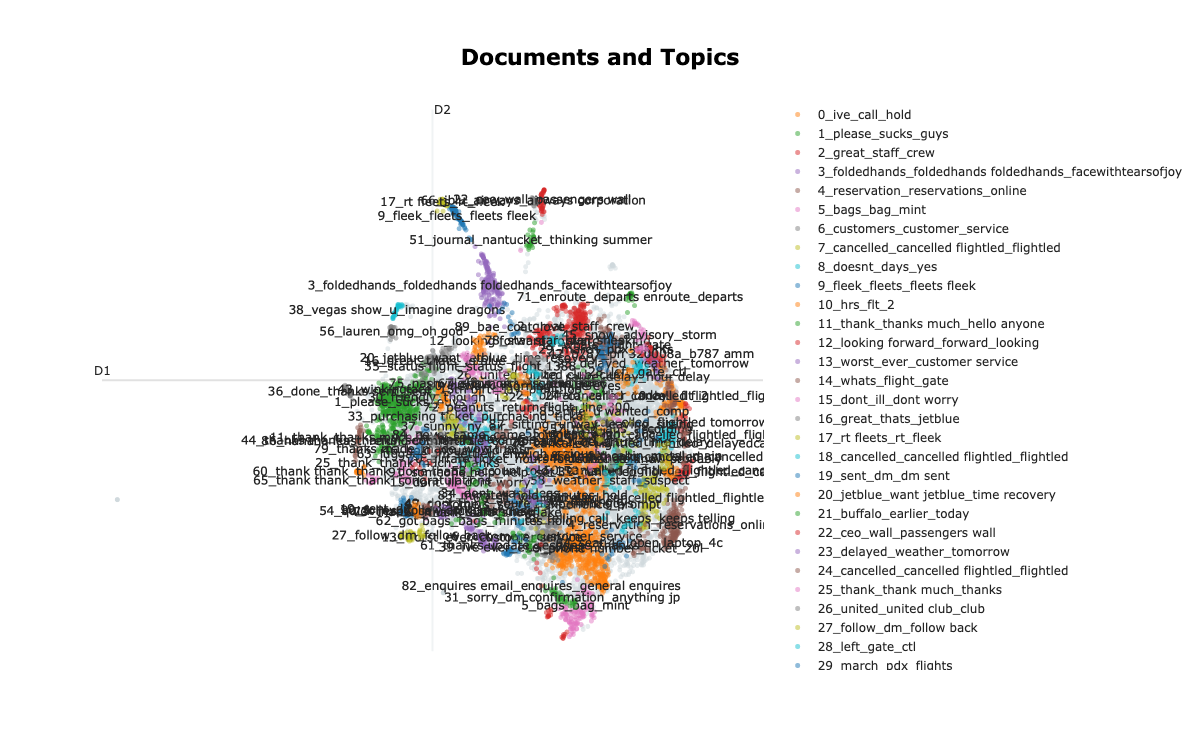

In [14]:
# Run the visualization with the original embeddings
# And viewing the original tweet text
bertmodel_twhinbert.visualize_documents(
    docs=list(df.text), embeddings=embeddings_twhinbert
)

umap_vis = UMAP(
    n_neighbors=n_neighbors,
    n_components=2,
    min_dist=min_dist,
    metric=metric_umap,
    random_state=random_state,
)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = umap_vis.fit_transform(embeddings_twhinbert)
bertmodel_twhinbert.visualize_documents(
    docs=list(df.text), reduced_embeddings=reduced_embeddings
)

#### Save model:

In [15]:
# bertmodel_twhinbert.save('../models/bertmodel_twhinbert', save_embedding_model=True)

#### To load:

In [10]:
bertmodel_twhinbert = BERTopic.load("../models/bertmodel_twhinbert")